# Back Test the ML Model in SageMaker

After training your XGBoost model (or any time series model), you want to back test it to derive a trading strategy. This example demonstrates how to load historical minute bar data and back test the XGBoost model easily on SageMaker. The procedure is as follows:

##### 1. Load Data from S3 and Prepare Data

Load the data from S3, and prepare the data with OHLCV, VWAP, TWAP, SMA5, SMA20, OBC, VROC as the features.

##### 2. Create Custom Strategy with Backtrader Framework

Create a custom strategy with the Backtrader framework to generate trading signals using the XGBoost model hosted on SageMaker.

##### 3. Run the Back Test

Run the back test to evaluate the performance of the trading strategy and the XGBoost model.

Fine-tune the Model and Strategy (Optional)

## Preparation

In [2]:
!pip install ta
!pip install backtrader

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
from io import StringIO

import ta
import backtrader as bt
import backtrader.analyzers as btanalyzers

import boto3
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

import matplotlib.pyplot as plt
from IPython.display import Image

## Back test parameters

In [415]:
endpoint = 'sagemaker-xgboost-2024-09-10-06-21-25-838'

bucket_name = 'your-data-bucket'
file_key = 'minutebars.csv'  
ticker = 'HSBA.L'
#ticker = 'ULVR.L'


config = {
'take_profit': 0.001,
'stop_loss': 0.005,
'long_threshold': 0.6,
'trade_size': 100,
'max_position': 1000
}

now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d %H:%M:%S")
imagefl = f"results/chart-{ticker}-{timestamp_str}.png"

## Load back test market data

In [416]:
s3 = boto3.client('s3')
# the back test data
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
data = obj['Body'].read().decode('utf-8')

# Convert to DataFrame
df = pd.read_csv(StringIO(data))
df = df[(df['ticker'] == ticker) & (df['volume'] != 0) & (df['close'] != 0) & (df['twap'] != 0)]
df['bucket'] = pd.to_datetime(df['bucket'])
df.set_index('bucket', inplace=True)
#df = df.head(100)
#df = df.iloc[3000:3100]
df = df.tail(600)
df

,ticker,trades,open,high,low,close,volume,vwap,twap
bucket,,,,,,,,,
2024-07-30 13:31:00,HSBA.L,28,672.8,673.5,672.7,673.5,19716,673.054818,673.073671
2024-07-30 13:32:00,HSBA.L,15,673.5,673.8,673.4,673.8,15524,673.612265,673.562272
2024-07-30 13:33:00,HSBA.L,27,673.9,674.3,673.9,674.3,21756,674.064382,674.048436
2024-07-30 13:34:00,HSBA.L,39,674.3,674.5,674.2,674.5,12824,674.401825,674.406902
2024-07-30 13:35:00,HSBA.L,44,674.4,674.5,674.0,674.5,35213,674.243512,674.258014
...,...,...,...,...,...,...,...,...,...
2024-07-31 15:25:00,HSBA.L,93,704.0,704.4,704.0,704.3,51184,704.219899,704.234064
2024-07-31 15:26:00,HSBA.L,82,704.3,704.6,704.3,704.3,32667,704.422338,704.421387
2024-07-31 15:27:00,HSBA.L,50,704.4,704.7,704.4,704.7,31487,704.575444,704.633786


## Invoke model to generate signal

In [417]:
def generate_signal(o, h, l, c, v, vwap, twap, sma5, sma20, obv, vroc):
    # Create a numpy array with the input data
    input_data = pd.DataFrame({
        'open': [o],
        'high': [h],
        'low': [l],
        'close': [c],
        'volume': [v],
        'vwap': [vwap],
        'twap': [twap],
        'SMA_5': [sma5],
        'SMA_20': [sma20],
        'OBV': [obv],
        'VROC': [vroc]
    })
    serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
    data = serializer.serialize(input_data)

    # Initialize SageMaker predictor
    predictor = Predictor(
        endpoint_name=endpoint,
        sagemaker_session=sagemaker.Session(),
        serializer=CSVSerializer(content_type="text/csv"),
        deserializer=JSONDeserializer()
    )
    
    # Get the prediction from the deployed model
    result = predictor.predict(data, initial_args={'ContentType': 'text/csv'})
    score = result['predictions'][0]['score']
    
    return score

## Back test by backtrader framework

In [418]:
# Custom indicator to calculate OBV
class OBV(bt.Indicator):
    lines = ('obv',)
    params = (('_movav', bt.indicators.SMA),)

    plotinfo = dict(subplot=False)

    def __init__(self):
        self.addminperiod(2)
        self.obv = 0.0

    def next(self):
        if len(self.data.close) > 1:  # first iteration
            if self.data.close[0] > self.data.close[-1]:
                self.obv += self.data.volume[0]
            elif self.data.close[0] < self.data.close[-1]:
                self.obv -= self.data.volume[0]
        else:
            self.obv = self.data.volume[0]

        self.lines.obv[0] = self.obv
        
class CustomIndicators(bt.Indicator):
    lines = ('sma5', 'sma20', 'obv', 'vroc')
    params = (('vroc_period', 14),)

    def __init__(self):
        self.obv = OBV(self.data)
        self.sma5 = bt.indicators.SMA(self.data.close, period=5)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.vroc = bt.indicators.ROC(self.data.volume, period=self.p.vroc_period)

# Custom strategy
class XGBoostStrategy(bt.Strategy):
    def __init__(self):
        self.custom_indicators = CustomIndicators()
        self.order = None
        self.entry_price = None

        self.config = config

        self.cerebro.addanalyzer(btanalyzers.DrawDown, _name='dd')
        self.cerebro.addanalyzer(btanalyzers.SharpeRatio_A, _name='sharpe', riskfreerate=0.02, timeframe=bt.TimeFrame.Minutes, compression=1440)
        self.cerebro.addanalyzer(btanalyzers.SQN, _name='sqn')
        self.cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='ta')
        self.cerebro.addanalyzer(btanalyzers.Transactions, _name='tx')


    def next(self):
        # Make prediction using SageMaker endpoint
        up_singal = generate_signal(
            self.data.open[0], self.data.high[0], self.data.low[0], self.data.close[0], 
            self.data.volume[0], self.data.vwap[0], self.data.twap[0],
            self.custom_indicators.sma5[0], self.custom_indicators.sma20[0],
            self.custom_indicators.obv[0], self.custom_indicators.vroc[0])
        
        fLong=(up_singal>self.config['long_threshold'])
        fClose = False

        cl=self.data.close[0]
        if self.position is not None:
            if self.position.size >= self.config['max_position']:
                fLong = False
            if self.position.size > 0:
                if cl>=self.limitPrice or cl<=self.stopPrice:
                    fClose = True
        if fLong:
            self.order=self.buy(size=self.config['trade_size'])
            self.limitPrice=cl+self.config['take_profit']*cl
            self.stopPrice=cl-self.config['stop_loss']*cl
        if fClose:
            self.order=self.sell(size=self.config['trade_size'])


    def notify_order(self, order):
        dt=self.datas[0].datetime.datetime(0)

        if order.status in [order.Completed]:
            if order.isbuy():
                print(
                    '[%s] BUY EXECUTED, Price: %.2f, PNL: %.2f, Value: %.2f' %
                         (dt,order.executed.price,order.executed.pnl,self.broker.getvalue()))
            else:  # Sell
                print('[%s] SELL EXECUTED, Price: %.2f, PNL: %.2f, Value: %.2f' %
                         (dt,order.executed.price,order.executed.pnl,self.broker.getvalue()))

    def stop(self):
        self.log(f'Final Portfolio Value: {self.broker.getvalue():.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')


In [419]:
class BackTestAlgo():
    def __init__(self, strategy):
        self.cerebro = bt.Cerebro()  
        # Set initial capital
        self.cerebro.broker.setcash(100000.0)
        self.cerebro.broker.setcommission(commission=0)
        self.cerebro.addstrategy(strategy)

        self.portfolioStartValue=self.cerebro.broker.getvalue()

    def adddata(self, data):
        # Add data feed
        self.cerebro.adddata(data)


    def performance(self):      
        #Get the results we are interested in
        analyzer=self.thestrat.analyzers.ta.get_analysis()
        if (analyzer.total['total'] > 0):
            total_open = analyzer.total.open
            # total_closed = analyzer.total.closed
            total_closed = analyzer.total.get('closed', 0)
            total_won = analyzer.won.total
            total_lost = analyzer.lost.total
            win_streak = analyzer.streak.won.longest
            lose_streak = analyzer.streak.lost.longest
            pnl_net = round(analyzer.pnl.net.total,2)
            strike_rate = (total_won / total_closed) * 100
            self.strike_rate=strike_rate
            #Designate the rows
            h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
            h2 = ['Strike Rate', 'Win Streak', 'Losing Streak', 'PnL Net']
            h3 = ['DrawDown Pct','MoneyDown', '', '']
            self.total_closed=total_closed


            dd_analyzer=self.thestrat.analyzers.dd.get_analysis()
            self.max_drawdown=dd_analyzer.max.drawdown
            r1 = [total_open, total_closed,total_won,total_lost]
            r2 = [('%.2f%%' %(strike_rate)), win_streak, lose_streak, pnl_net]
            r3 = [('%.2f%%' %(dd_analyzer.max.drawdown)), dd_analyzer.max.moneydown, '', '']

            #Check which set of headers is the longest.
            header_length = max(len(h1),len(h2),len(h3))
            #Print the rows
            print_list = [h1,r1,h2,r2,h3,r3]
            row_format ="{:<15}" * (header_length + 1)
            print("Trade Analysis Results:")
            for row in print_list:
                print(row_format.format('',*row))

            self.pnl = self.cerebro.broker.getvalue()-self.portfolioStartValue

            sharpe_analyzer = self.thestrat.analyzers.sharpe.get_analysis()
            self.sharpe_ratio = sharpe_analyzer['sharperatio']
            if self.sharpe_ratio is None:
                self.sharpe_ratio=0

            print('[Total PnL:%.2f, Sharpe ratio: %.2f]' % (self.pnl, self.sharpe_ratio))

            # plot
            fig = self.cerebro.plot(volume=False, style='candle')
            plt.savefig(imagefl)
            plt.show()
        else:
            print("there is no trade !!!")

    def run(self):
        thestrats = self.cerebro.run()
        self.thestrat = thestrats[0]
        self.performance()


In [420]:
class MyDataFeed(bt.feeds.PandasData):
    lines = ('vwap', 'twap')
    params = (
        ('vwap', 7),
        ('twap', 8),
    )

In [421]:
%matplotlib inline

## Run the back test

In [422]:
data = MyDataFeed(
    dataname=df,
    datetime=None,
    open='open',
    high='high',
    low='low',
    close='close',
    volume='volume',
    openinterest=-1  
    )

algo = BackTestAlgo(XGBoostStrategy)

# Add data feed
algo.adddata(data)

# Run backtest
print('Starting Portfolio Value: %.2f' % algo.cerebro.broker.getvalue())
algo.run()
print('Final Portfolio Value: %.2f' % algo.cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
[2024-07-30 14:03:00] BUY EXECUTED, Price: 675.20, PNL: 0.00, Value: 99980.00
[2024-07-30 14:12:00] SELL EXECUTED, Price: 675.90, PNL: 70.00, Value: 100070.00
[2024-07-30 15:10:00] BUY EXECUTED, Price: 675.80, PNL: 0.00, Value: 100070.00
[2024-07-30 15:22:00] SELL EXECUTED, Price: 676.50, PNL: 70.00, Value: 100140.00
[2024-07-31 07:01:00] BUY EXECUTED, Price: 689.50, PNL: 0.00, Value: 100230.00
[2024-07-31 07:02:00] SELL EXECUTED, Price: 691.10, PNL: 160.00, Value: 100300.00
[2024-07-31 07:03:00] BUY EXECUTED, Price: 690.70, PNL: 0.00, Value: 100380.00
[2024-07-31 07:05:00] SELL EXECUTED, Price: 692.60, PNL: 190.00, Value: 100490.00
[2024-07-31 07:06:00] BUY EXECUTED, Price: 693.50, PNL: 0.00, Value: 100700.00
[2024-07-31 07:07:00] SELL EXECUTED, Price: 696.90, PNL: 340.00, Value: 100830.00
[2024-07-31 07:08:00] BUY EXECUTED, Price: 692.90, PNL: 0.00, Value: 100820.00
[2024-07-31 07:10:00] SELL EXECUTED, Price: 694.30, PNL: 140.00, Value: 100970.00
[

<IPython.core.display.Javascript object>

Final Portfolio Value: 101070.00


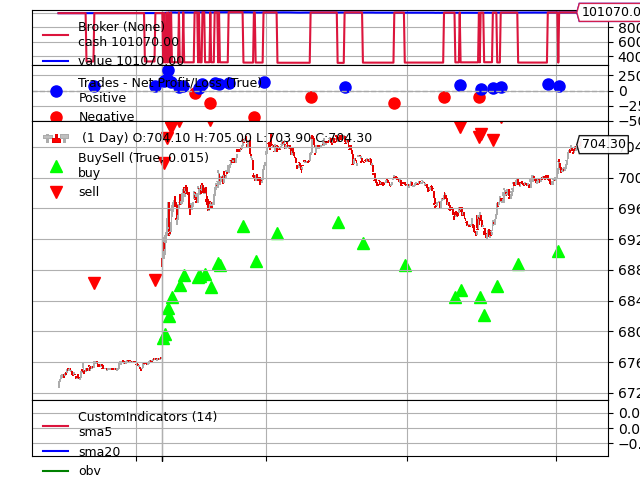

In [423]:
Image(filename=imagefl) 